# Download and tokenize the corpus

In [1]:
import os

DATA_PATH = "./data"

with open(os.path.join(DATA_PATH, "tiny_shakespeare.txt"), "r", encoding="utf-8") as fp:
    corpus = fp.read()

corpus[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [2]:
vocab = sorted(list(set(corpus)))
c_to_i = {c: i for i, c in enumerate(vocab)}
i_to_c = {i: c for i, c in enumerate(vocab)}


def encode(txt):
    return [c_to_i[c] for c in txt]

def decode(i_lst):
    return ''.join([i_to_c[i] for i in i_lst])

txt = "hello world!"
print(encode(txt))
print(decode(encode(txt)))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
hello world!


In [3]:
import torch

data = torch.tensor(encode(corpus), dtype=torch.long)
data[:10]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])

In [4]:
num_train_ex = int(0.9 * len(data))
train_data = data[:num_train_ex]
val_data = data[num_train_ex:]

Block size, also known as context length, is the maximum input length.
In a block size of 8, we have 8 (input, output) training examples, as shown below.

This way, the transformer will have seen examples with input length ranging from 1 to `block_size`. This is useful because when we sample during inference (i.e. generate), we want the transformer to be able to complete sequences as short as 1 token.

In [5]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [6]:
for t in range(block_size):
    print('input:', train_data[:t + 1], 'outputs:', train_data[t + 1])

input: tensor([18]) outputs: tensor(47)
input: tensor([18, 47]) outputs: tensor(56)
input: tensor([18, 47, 56]) outputs: tensor(57)
input: tensor([18, 47, 56, 57]) outputs: tensor(58)
input: tensor([18, 47, 56, 57, 58]) outputs: tensor(1)
input: tensor([18, 47, 56, 57, 58,  1]) outputs: tensor(15)
input: tensor([18, 47, 56, 57, 58,  1, 15]) outputs: tensor(47)
input: tensor([18, 47, 56, 57, 58,  1, 15, 47]) outputs: tensor(58)


Now let's batch

In [7]:
batch_size = 4 # Number of independent sequences processed in parallel
block_size = 8 # Maximum context length

torch.manual_seed(1234)

def get_batch(data):
    start_positions = torch.randint(len(data) - block_size, (batch_size,))
    input = torch.stack([data[i: i + block_size] for i in start_positions])
    output = torch.stack([data[i + 1: i + 1 + block_size] for i in start_positions])
    return input, output

def get_train_batch(): return get_batch(train_data)
def get_val_batch(): return get_batch(val_data)

get_train_batch()

(tensor([[51, 59, 57, 58,  1, 39, 61, 39],
         [63,  6,  1, 61, 46, 53,  5, 57],
         [39,  1, 41, 46, 47, 50, 42, 10],
         [53, 59, 10,  0, 37, 53, 59,  1]]),
 tensor([[59, 57, 58,  1, 39, 61, 39, 63],
         [ 6,  1, 61, 46, 53,  5, 57,  1],
         [ 1, 41, 46, 47, 50, 42, 10,  0],
         [59, 10,  0, 37, 53, 59,  1, 57]]))

In the tensors above, we have 32 training examples, 8 for each row. For the first row:
* input=[51], i.e. inputs[0:1]; output=59, i.e. outputs[0][0];
* input=[51, 59], i.e. inputs[0:2]; output=57, i.e. outputs[0][1];
* ...

# Bigram language model

In [8]:
from torch.nn import functional as F

class BigramLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.time_embed_layer = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, input_ids, targets=None):
        """
        Args:
            input_ids (`torch.LongTensor` of size `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary.
            targets (`torch.LondTensor` of size `(batch_size, sequence_length)`):
                Indices of target tokens in the vocabulary.
        """
        # (batch_size, seq_length, embed_dim)
        time_embeds = self.time_embed_layer(input_ids)

        loss = None
        if targets is not None:
            # Since embed_dim = vocab_size, time_embeds can be thought of as logits.
            # The task is: given the current word, predict the next word.

            batch_size, seq_len, embed_dim = time_embeds.size()
            time_embeds = time_embeds.view(batch_size * seq_len, embed_dim)
            targets = targets.view(batch_size * seq_len)
            loss = F.cross_entropy(time_embeds, targets)

        return time_embeds, loss

    def generate(self, input_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            # (batch_size, seq_len, embed_dim)
            logits, _ = self(input_ids)

            # Keep the logits for the last token only.
            # (batch_size, vocab_size == embed_dim)
            logits = logits[:, -1, :]

            # (batch_size, vocab_size)
            probs = F.softmax(logits, dim=1)

            # Sample from the distribution (one sample (an index) from eahc row)
            # (batch_size, 1)
            next_ids = torch.multinomial(probs, num_samples=1)

            # Append the sample to the running sequence
            # (batch_size, seq_len + 1)
            input_ids = torch.cat((input_ids, next_ids), dim=1)
        return input_ids

In [9]:
lm = BigramLanguageModel(len(vocab))
input_ids, targets = get_train_batch()
input_ids, targets

(tensor([[58, 46,  1, 57, 43, 43, 57,  1],
         [43,  1, 53, 44,  1, 58, 46, 43],
         [58,  1, 47, 57,  5, 58,  0, 63],
         [ 1, 53, 44,  1, 44, 50, 39, 58]]),
 tensor([[46,  1, 57, 43, 43, 57,  1, 46],
         [ 1, 53, 44,  1, 58, 46, 43,  1],
         [ 1, 47, 57,  5, 58,  0, 63, 53],
         [53, 44,  1, 44, 50, 39, 58, 58]]))

In [10]:
outputs, loss = lm(input_ids, targets)
outputs.size(), loss

(torch.Size([32, 65]), tensor(4.2638, grad_fn=<NllLossBackward0>))

For a language modelling head that assigns equal probability to all words, i.e. maximum entropy, the probability of each word would be 1/65, so the loss would be $-\ln(1/65) \approx 4.17$ (selecting one of those 1/65, where the target one-hot vector has a 1).

In [11]:
torch.softmax(torch.tensor([1/65] * 65, dtype=torch.float32), 0)

tensor([0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154])

In [12]:
gen_input_ids = torch.zeros((1, 1), dtype=torch.long)
gen_ids = lm.generate(gen_input_ids, max_new_tokens=100)
decode(gen_ids[0].tolist())

"\nQB:L$J:QxkURQxsa vZNbSvahVTKvJRWDDlBXQj zlR&3p  tKma'bxVsn;kjOFBjqaWQj fkTWZQ;YIMlcGPPPiia?sml.LZMEQ"

# Train

In [13]:
optimizer = torch.optim.AdamW(lm.parameters(), lr=1e-3)

In [14]:
import tqdm

losses = []

BATCH_SIZE = 32
for steps in tqdm.tqdm(range(10000), desc="Training"):
    input_ids, targets = get_train_batch()

    logits, loss = lm(input_ids, targets)
    optimizer.zero_grad(set_to_none=True) # zero all gradients from prev step
    loss.backward() # compute gradients for all parameters
    optimizer.step() # use those gradients to update parameters
    losses.append(loss.item())

print(loss.item())

Training: 100%|██████████| 10000/10000 [00:03<00:00, 3026.38it/s]

2.763643264770508


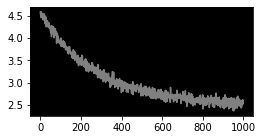

In [15]:
# prompt: plot losses, gray line on a dark background, smoothed over 10 steps, small figure size

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2))
plt.plot(
    [
        sum(losses[i : i + 10]) / 10
        for i in range(0, len(losses), 10)
    ],
    color="gray",
)
plt.gca().set_facecolor("black")
plt.show()

In [16]:
gen_input_ids = torch.zeros((1, 1), dtype=torch.long)
gen_ids = lm.generate(gen_input_ids, max_new_tokens=100)
decode(gen_ids[0].tolist())

'\nAr:\nLAngomyqwet gan ithenthwin? bx?\nonenoth TZf neeqknd hau fomyou aropoun luder\nBe heit noures; n f'

# Self-attention

Assume we are given a tensor as the one below, of size (batch size, doc_len, emb_dim).

In [17]:
x = torch.tensor([
    [[1, 3],
     [2, 1],
     [0, 1]],

    [[0, 1],
     [5, 4],
     [0, 0]]
]).float()

We would like to produce another where the representation of word $t \in \{1, \ldots, \text{doc\_len}\}$ is the sum representations of words $1, \ldots, t$.

In [ ]:
target = torch.tensor([
    [[1, 3],
     [3, 4],
     [3, 5]],

    [[0, 1],
     [5, 5],
     [5, 5]]
]).float()

Here is the inefficient way.

In [19]:
x_bow = torch.zeros_like(x)
batch_size, doc_len, emb_dim = x.size()

for b in range(batch_size):
    for t in range(doc_len):
        x_bow[b, t] = x[b, :t + 1].sum(dim=0)
x_bow.allclose(target)

True

And now for the efficient way.

In [20]:
mask = torch.tril(torch.ones(3,3))
print(mask)
print(x)
mask @ x

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[[1., 3.],
         [2., 1.],
         [0., 1.]],

        [[0., 1.],
         [5., 4.],
         [0., 0.]]])


tensor([[[1., 3.],
         [3., 4.],
         [3., 5.]],

        [[0., 1.],
         [5., 5.],
         [5., 5.]]])

We are multiplying mask of size (3, 3) with x of size (2, 3, 2). Pytorch will know to multiply mask with each (3, 2) element in x.

Now let's do averaging instead of summing.

In [21]:
mask = torch.tril(torch.ones(3, 3))
mask[mask == 0] = float("-inf")
mask = torch.softmax(mask, dim=1)
print(mask)

mask @ x

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])


tensor([[[1.0000, 3.0000],
         [1.5000, 2.0000],
         [1.0000, 1.6667]],

        [[0.0000, 1.0000],
         [2.5000, 2.5000],
         [1.6667, 1.6667]]])

At this point, when computing the representation of the current token, all previous tokens are given the same weight.
This is not great. Consider "I had a pizza, it was very tasty". When representing "it", (the representation of) "pizza" should have a higher weight that that of "had", for instance.

For a character-level model, the representation of a e.g. vowel should depend on specific previous consonants.

We want such weights to be data dependent. This is the problem that self-attention solves.

Self-attention:
* Given a token, call it the current token, compute an affinity score between the current token and every token in the sequence, resulting in T affinity scores.
* To accomplish this, every token emits three vectors: a query, a key, and a value:
  * query of a token: intuitively expresses what that token is looking for when considring other tokens. "It" looking for a referrant.
  * key: information content that other queries can match against.
  * value: what the token communicates about itself to other tokens.
* The affinity score between the current token and another token is the dot product between query(current token) and key(other token).
* When re-representing current token, we compute affinity between the current token and all previous tokens, including current token. We then represent current token as the weighted average of the values of all these tokens, where the weights are the affinity scores.
* Summary: key (what I contain), query (what I am looking for), value (what I will communicate about myself).

Analogy:
* Directed graph. Every node has some value vector. This expresses the information content it communicates to nodes that it points to.
* Given a node, compute a weighted average of the nodes that point to this node. We want the weights to be data dependent.

In [24]:
batch_size, doc_len, emb_dim = x.size()
x, x.size()

(tensor([[[1., 3.],
          [2., 1.],
          [0., 1.]],
 
         [[0., 1.],
          [5., 4.],
          [0., 0.]]]),
 torch.Size([2, 3, 2]))

In [83]:
B, T, C = x.size()
head_size = 16 # the dimension of the key, query, and value vectors

key_layer = torch.nn.Linear(emb_dim, head_size, bias=False)
query_layer = torch.nn.Linear(emb_dim, head_size, bias=False)
value_layer = torch.nn.Linear(emb_dim, head_size, bias=False)

query = query_layer(x) # (B, T, C)
key = key_layer(x)     # (B, T, C)
value = value_layer(x) # (B, T, C)

# (B, T, C) @ (B, C, T) -> (B, T, T)
wei = query @ key.transpose(2, 1)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = torch.softmax(wei, dim=-1)

out = wei @ value

out.size()

torch.Size([2, 3, 16])

Notes:
* There is no notion of space. This is why we need positional encoding. Meaning of a token might differ with position. E.g. verb particles in German added to the end of the sentence Self-attention vs convolution: notion of space exists in convolution.
* Above we are implementing a _decoder_ / _masked_ self-attention block; when representing the current token, we do NOT consider future tokens. By contrast, in _encoder_ block, this restriction is removed; implemented by removing the masking, i.e. removing `wei = wei.masked_fill(tril == 0, float("-inf"))`. The decoder is appropriate for language modelling; encoder for e.g. classification tasks, such as sentiment analysis.
* In self-attention, keys, querries, and values, are computed from the same source. In _cross-attention_, also referred to as _encoder-decoder attention_ when using an encoder-decoder architecture, the querries are computed from current source, but keys and values from another source, from which we would like to pull information; for instance, from the (output of the) encoder blocks, that represent some context we'd like to condition on.
* _Scaled_ attention divides `wei` by `sqrt(head_size)`. Assume querries and keys are unit Gaussians, i.e. follow a Gaussian distribution with unit variance. If we do not divide, the variance of wei will be multiplied by `head_size`. If we divide, it stays unit variance. Stated differently, the values in `wei` will simply be larger. As a result, the softmax will sharper, getting further away from a uniform, sharping towards the max, converging to a one-hot vector.
* _Multi-head_ attention: apply multiple attentions in parallel (using different query, key, and value matrices) and concatenate their results. Having different initialisations, they capture different interactions. Different local minima.

In [122]:
Q = torch.randn(B, T, head_size)
K = torch.randn(B, T, head_size)
wei_1 = Q @ K.transpose(1, 2)
wei_2 = Q @ K.transpose(1, 2) / head_size**0.5

print(Q.var())
print(K.var())
print(wei_1.var())
print(wei_2.var())

tensor(0.8659)
tensor(0.7215)
tensor(8.2634)
tensor(0.5165)
